In [1]:
import collections
import cProfile
import hashlib
import itertools
import math
import os
import pstats
import string
import re

from datetime import datetime
from io import StringIO
from tqdm.notebook import tqdm as tqdm

import torch
import torchaudio
from torch import nn, topk
from torch.optim import Adadelta, Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS, LIBRISPEECH
from torchaudio.transforms import MFCC, Resample

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Empty CUDA cache
torch.cuda.empty_cache()

# Profiling performance
pr = cProfile.Profile()
pr.enable()

In [2]:
audio_backend = "soundfile"
torchaudio.set_audio_backend(audio_backend)

device = "cuda" if torch.cuda.is_available() else "cpu"
num_devices = torch.cuda.device_count()
# num_devices = 1
print(num_devices, "GPUs")

# max number of sentences per batch
# batch_size = 2048
# batch_size = 512
# batch_size = 256
batch_size = 64

training_percentage = 90.
validation_percentage = 5.

data_loader_training_params = {
    "num_workers": 0,
    "pin_memory": False,
    "shuffle": True,
    "drop_last": True,
}
data_loader_validation_params = data_loader_training_params.copy()
data_loader_validation_params["shuffle"] = False

non_blocking = data_loader_training_params["pin_memory"]


# text preprocessing

char_null = "-"
char_pad = "*"
char_apostrophe = "'"

labels = [char_null + char_pad + char_apostrophe + string.ascii_lowercase]

# excluded_dir = ["_background_noise_"]
# folder_speechcommands = './SpeechCommands/speech_commands_v0.02'
# labels = [char_null, char_pad] + [d for d in next(os.walk(folder_speechcommands))[1] if d not in excluded_dir]


# audio

sample_rate_original = 16000
sample_rate_new = 8000
resample = Resample(sample_rate_original, sample_rate_new)
# resample = None

n_mfcc = 13
melkwargs = {
    'n_fft': 512,
    'n_mels': 20,
    'hop_length': 80,  # (160, 80)
}
mfcc = MFCC(sample_rate=sample_rate_original, n_mfcc=n_mfcc, melkwargs=melkwargs).to(device)
# mfcc = None


# Optimizer

optimizer_params_adadelta = {
    "lr": 1.0,
    "eps": 1e-8,
    "rho": 0.95,
    # "weight_decay": .01,
}

optimizer_params_adam = {
    "lr": .05,
    "eps": 1e-8,
    "weight_decay": .01,
}

optimizer_params_sgd = {
    "lr": .001,
    "weight_decay": .0001,
}

Optimizer = Adadelta
optimizer_params = optimizer_params_adadelta

gamma = 0.95


# Model

lstm_params = {
    "num_layers": 3,
    "batch_first": False,
    "bidirectional": False,
    "dropout": 0.,
}

clip_norm = 0.  # 10.

zero_infinity = False

max_epoch = 200
mod_epoch = 10

dtstamp = datetime.now().strftime("%y%m%d.%H%M%S")
print(dtstamp)

2 GPUs
200311.142258


# Text encoding

In [3]:
class Coder:
    def __init__(self, labels):
        labels = list(collections.OrderedDict.fromkeys(list("".join(labels))))
        self.length = len(labels)
        enumerated = list(enumerate(labels))
        flipped = [(sub[1], sub[0]) for sub in enumerated]

        d1 = collections.OrderedDict(enumerated)
        d2 = collections.OrderedDict(flipped)
        self.mapping = {**d1, **d2}

    def _map(self, iterable):
        # iterable to iterable
        return [self.mapping[i] for i in iterable]

    def encode(self, iterable):
        if isinstance(iterable[0], list):
            return [self.encode(i) for i in iterable]
        else:
            return self._map(iterable)

    def decode(self, tensor):
        if isinstance(tensor[0], list):
            return [self.decode(t) for t in tensor]
        else:
            return "".join(self._map(tensor))


coder = Coder(labels)
encode = coder.encode
decode = coder.decode
vocab_size = coder.length
print(vocab_size)

29


# Dataset

In [4]:
class IterableMemoryCache:

    def __init__(self, iterable):
        self.iterable = iterable
        self._iter = iter(iterable)
        self._done = False
        self._values = []

    def __iter__(self):
        if self._done:
            return iter(self._values)
        return itertools.chain(self._values, self._gen_iter())

    def _gen_iter(self):
        for new_values in self._iter:
            self._values.append(new_value)
            yield new_value
        self._done = True

    def __len__(self):
        return len(self._iterable)


class MapMemoryCache(torch.utils.data.Dataset):
    """
    Wrap a dataset so that, whenever a new item is returned, it is saved to memory.
    """

    def __init__(self, dataset):
        self.dataset = dataset
        self._cache = [None] * len(dataset)

    def __getitem__(self, n):
        if self._cache[n]:
            return self._cache[n]

        item = self.dataset[n]
        self._cache[n] = item

        return item

    def __len__(self):
        return len(self.dataset)


class Processed(torch.utils.data.Dataset):

    def __init__(self, process_datapoint, dataset):
        self.process_datapoint = process_datapoint
        self.dataset = dataset
        
    def __getitem__(self, n):
        try:
            item = self.dataset[n]
            return self.process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return None

    def __next__(self):
        try:
            item = next(self.dataset)
            return self.process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return self.__next__()
        
    def __len__(self):
        return len(self.dataset)

In [5]:
def process_datapoint(item):
    transformed = item[0].to(device, non_blocking=non_blocking)
    target = item[2].lower().replace(" ", char_pad)
    # target = "".join(filter(str.isalnum, target))
    target = "".join(c for c in target if c.isalnum() or c == char_pad)
    # pick first channel, apply mfcc, tranpose for pad_sequence
    transformed = mfcc(transformed)
    transformed = transformed[0, ...].transpose(0, -1)
    # transformed = transformed.view(-1, 1)
    target = encode(target)
    target = torch.tensor(target, dtype=torch.long, device=transformed.device)
    return transformed, target

In [6]:
def datasets():

    root = "./"
    def create(tag):
        data = LIBRISPEECH(root, tag, download=True)
        data = Processed(process_datapoint, data)
        data = MapMemoryCache(data)
        return data

    return create("train-clean-100"), create("dev-clean"), None


training, validation, _ = datasets()

In [7]:
def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
        filename: File path of the data sample.
        validation_percentage: How much of the data set to use for validation.
        testing_percentage: How much of the data set to use for testing.

    Returns:
        String, one of 'training', 'validation', or 'testing'.
    """
    
    MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

    base_name = os.path.basename(filename)

    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name).encode("utf-8")
    
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) % (MAX_NUM_WAVS_PER_CLASS + 1)) * (100.0 / MAX_NUM_WAVS_PER_CLASS))
    
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'

    return result


def filter_speechcommands(tag, training_percentage, data):
    if training_percentage < 100.:
            testing_percentage = (100. - training_percentage - validation_percentage)
            which_set_filter = lambda x: which_set(x, validation_percentage, testing_percentage) == tag
            data._walker = list(filter(which_set_filter, data._walker))
    return data


def datasets():

    root = "./"
    def create(tag):
        data = SPEECHCOMMANDS(root, download=True)
        data = filter_speechcommands(tag, training_percentage, data)
        data = Processed(process_datapoint, data)
        data = MapMemoryCache(data)
        return data

    return create("training"), create("validation"), create("testing")


# training, validation, _ = datasets()

In [8]:
def collate_fn(batch):

    tensors = [b[0] for b in batch if b]
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.transpose(1, -1)

    targets = [b[1] for b in batch if b]
    target_lengths = torch.tensor(
        [target.shape[0] for target in targets], dtype=torch.long, device=tensors.device
    )
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

    # print(targets.shape)
    # print(decode(targets.tolist()))
    
    return tensors, targets, target_lengths

# Model

[Wav2Letter](https://github.com/LearnedVector/Wav2Letter/blob/master/Google%20Speech%20Command%20Example.ipynb)

In [9]:
def weight_init(m): 
    if isinstance(m, nn.Linear):
        size = m.weight.size()
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        variance = math.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)


class PrintLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x)
        return x
    

class Wav2Letter(nn.Module):
    """Wav2Letter Speech Recognition model
        https://arxiv.org/pdf/1609.03193.pdf
        This specific architecture accepts mfcc or power spectrums speech signals

        Args:
            num_features (int): number of mfcc features
            num_classes (int): number of unique grapheme class labels
    """

    def __init__(self, num_features, num_classes):
        super().__init__()

        # Conv1d(in_channels, out_channels, kernel_size, stride)
        self.layers = nn.Sequential(
            nn.Conv1d(num_features, 250, 48, 2),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            nn.Conv1d(250, 2000, 32),
            nn.ReLU(),
            nn.Conv1d(2000, 2000, 1),
            nn.ReLU(),
            nn.Conv1d(2000, num_classes, 1),
        )

    def forward(self, batch):
        """Forward pass through Wav2Letter network than
            takes log probability of output
        Args:
            batch (int): mini batch of data
            shape (batch, num_features, frame_len)
        Returns:
            Tensor with shape (batch_size, num_classes, output_len)
        """
        # batch: (batch_size, num_features, seq_len)
        y_pred = self.layers(batch)
        # y_pred: (batch_size, num_classes, output_len)
        y_pred = y_pred.transpose(-1, -2)
        # y_pred: (batch_size, output_len, num_classes)
        return nn.functional.log_softmax(y_pred, dim=-1)    

In [10]:
class LSTMModel(nn.Module):

    def __init__(self, num_features, num_classes, num_layers, bidirectional, dropout, batch_first):
        super().__init__()
        
        directions = bidirectional + 1

        self.layer = nn.LSTM(
            num_features, num_classes,
            num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=batch_first
        )
        # self.hidden2class = nn.Linear(directions*num_classes, num_classes)

    def forward(self, batch):
        # self.layer.flatten_parameters()
        # print("forward")
        # batch: batch, num_features, seq_len
        # print(batch.shape)
        batch = batch.transpose(-1, -2).contiguous()
        # batch: batch, seq_len, num_features
        # print(batch.shape)
        outputs, _ = self.layer(batch)
        # outputs: batch, seq_len, directions*num_features
        # outputs = self.hidden2class(outputs)
        # outputs: batch, seq_len, num_features
        # print(outputs.shape)
        return nn.functional.log_softmax(outputs, dim=-1)    

# Word Decoder

In [11]:
def greedy_decoder(outputs):
    """Greedy Decoder. Returns highest probability of class labels for each timestep

    Args:
        outputs (torch.Tensor): shape (input length, batch size, number of classes (including blank))

    Returns:
        torch.Tensor: class labels per time step.
    """
    _, indices = topk(outputs, k=1, dim=-1)
    return indices[..., 0]

# Train

In [12]:
loader_training = DataLoader(
    training, batch_size=batch_size, collate_fn=collate_fn, **data_loader_training_params
)

loader_validation = DataLoader(
    validation, batch_size=batch_size, collate_fn=collate_fn, **data_loader_validation_params
)

print(len(loader_training), len(loader_validation))

num_features = next(iter(loader_training))[0].shape[1]
print(num_features)

445 42
13


In [13]:
model = Wav2Letter(num_features, vocab_size)
# model = LSTMModel(num_features, vocab_size, **lstm_params)

model = torch.jit.script(model)
model = nn.DataParallel(model) if num_devices > 1 else model
model = model.to(device, non_blocking=non_blocking)
# model.apply(weight_init)

optimizer = Optimizer(model.parameters(), **optimizer_params)
# scheduler = ExponentialLR(optimizer, gamma=gamma)
# scheduler = ReduceLROnPlateau(optimizer)

criterion = torch.nn.CTCLoss(zero_infinity=zero_infinity)
# criterion = nn.MSELoss()
# criterion = torch.nn.NLLLoss()

best_loss = 1.

In [14]:
def forward_and_loss(inputs, targets, target_lengths):

    inputs = inputs.to(device, non_blocking=non_blocking)
    targets = targets.to(device, non_blocking=non_blocking)
    
    # keep batch first for data parallel
    outputs = model(inputs).transpose(0, 1)

    this_batch_size = outputs.shape[1]
    seq_len = outputs.shape[0]
    input_lengths = torch.full((this_batch_size,), seq_len, dtype=torch.long, device=outputs.device)
    
    # CTC    
    # outputs: input length, batch size, number of classes (including blank)
    # targets: batch size, max target length
    # input_lengths: batch size
    # target_lengths: batch size

    return criterion(outputs, targets, input_lengths, target_lengths)


def forward_and_decode(inputs, targets):
    output = model(inputs)
    output = output.transpose(0, 1)
    output = output[:, 0, :]
    output = greedy_decoder(output)
    output = decode(output.tolist())
    target = decode(targets.tolist()[0])

    print_length = 20
    output = output.ljust(print_length)[:print_length]
    target = target.ljust(print_length)[:print_length]

    return f"Epoch: {epoch:4}   Target: {target}   Output: {output}"

In [15]:
sum_loss_training = []
sum_loss_validation = []
gradient_norm = []
gradient_norm_training = []

with tqdm(total=max_epoch, unit_scale=1) as pbar:
    for epoch in range(max_epoch):
        model.train()

        sum_loss = 0.
        for inputs, targets, target_lengths in loader_training:

            loss = forward_and_loss(inputs, targets, target_lengths)
            sum_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            if clip_norm > 0:
                total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
                gradient_norm_training.append((epoch, total_norm))
                print(f"Epoch: {epoch:4}   Gradient: {total_norm:4.5f}")
            optimizer.step()

            pbar.update(1/len(loader_training))

        # Average loss
        sum_loss = sum_loss / len(loader_training)
        sum_loss_training.append((epoch, sum_loss))
        sum_loss_str = f"Epoch: {epoch:4}   Train: {sum_loss:4.5f}"
        
        # scheduler.step()
        # scheduler.step(sum_loss)
        
        with torch.no_grad():

            if not epoch % mod_epoch or epoch == max_epoch-1:

                total_norm = 0.
                for p in list(filter(lambda p: p.grad is not None, model.parameters())):
                    total_norm += p.grad.data.norm(2).item() ** 2                    
                total_norm = total_norm ** (1. / 2)
                gradient_norm.append(total_norm)
                print(f"Epoch: {epoch:4}   Gradient: {total_norm}")
                
                # Switch to evaluation mode
                model.eval()
        
                print(forward_and_decode(inputs, targets))

                sum_loss = 0.
                for inputs, targets, target_lengths in loader_validation:
                    sum_loss += forward_and_loss(inputs, targets, target_lengths).item()

                # Average loss
                sum_loss = sum_loss / len(loader_validation)
                sum_loss_validation.append((epoch, sum_loss))
                sum_loss_str += f"   Validation: {sum_loss:.5f}"

                print(forward_and_decode(inputs, targets))

                print(sum_loss_str)

                if sum_loss < best_loss:
                    # Save model
                    torch.save(model.state_dict(), f"./model.{dtstamp}.{epoch}.ph")
                    best_loss = sum_loss


Epoch:    0   Gradient: 6.186310441814044
Epoch:    0   Target: affairs*connected*wi   Output: --------------------
Epoch:    0   Target: we*will*hunt*wolves*   Output: --------------------
Epoch:    0   Train: 3.73166   Validation: 2.97911



KeyboardInterrupt: 

In [18]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    4218 MB |    9037 MB |   11601 GB |   11597 GB |
|       from large pool |     373 MB |    5192 MB |   11495 GB |   11495 GB |
|       from small pool |    3844 MB |    3846 MB |     106 GB |     102 GB |
|---------------------------------------------------------------------------|
| Active memory         |    4218 MB |    9037 MB |   11601 GB |   11597 GB |
|       from large pool |     373 MB |    5192 MB |   11495 GB |

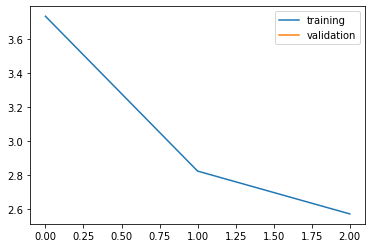

In [19]:
plt.plot(*zip(*sum_loss_training), label="training")
plt.plot(*zip(*sum_loss_validation), label="validation")

plt.legend()
plt.show()

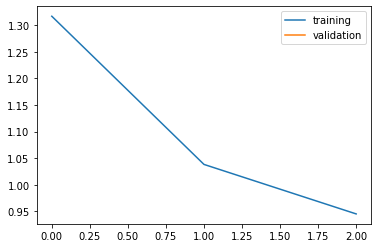

In [20]:
sum_loss_training = [(a, math.log(b)) for (a,b) in sum_loss_training]
sum_loss_validation = [(a, math.log(b)) for (a,b) in sum_loss_validation]

plt.plot(*zip(*sum_loss_training), label="training")
plt.plot(*zip(*sum_loss_validation), label="validation")

plt.legend()
plt.show()

In [21]:
# Save model
torch.save(model.state_dict(), f"./model.{dtstamp}.{epoch}.ph")

# Print performance
pr.disable()
s = StringIO()
ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime").print_stats(20)
print(s.getvalue())

         39849560 function calls (38985914 primitive calls) in 1562.462 seconds

   Ordered by: cumulative time
   List reduced from 2706 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       18    0.001    0.000 1562.460   86.803 base_events.py:1686(_run_once)
      198    0.000    0.000 1558.254    7.870 events.py:86(_run)
      198    0.000    0.000 1558.254    7.870 {method 'run' of 'Context' objects}
      134    0.000    0.000 1558.253   11.629 ioloop.py:735(_run_callback)
    76/14    0.001    0.000 1558.251  111.304 gen.py:716(run)
   126/41    0.000    0.000 1558.250   38.006 {method 'send' of 'generator' objects}
       12    0.000    0.000 1558.248  129.854 ioloop.py:690(<lambda>)
       12    0.000    0.000 1558.248  129.854 gen.py:784(inner)
    97/32    0.002    0.000 1558.245   48.695 gen.py:184(wrapper)
       84    0.000    0.000 1558.242   18.550 kernelbase.py:347(process_one)
       47    0.001    0.000 1558.240

In [52]:
# https://martin-thoma.com/word-error-rate-calculation/

def wer(r, h):
    """
    Calculation of WER with Levenshtein distance.

    Works only for iterables up to 254 elements (uint8).
    O(nm) time ans space complexity.
    """
    # initialisation
    import numpy
    d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]/len(r)


def forward_decode_wer(inputs, targets):
    output = model(inputs)
    # output = output.transpose(0, 1)
    output = greedy_decoder(output)

    output = decode(output.tolist())
    target = decode(targets.tolist())
    
    output = [o.replace(char_null, "").replace(char_pad, " ").strip().split(" ") for o in output]
    target = [o.replace(char_null, "").replace(char_pad, " ").strip().split(" ") for o in target]
    
    wers = [wer(a, b) for a, b in zip(output, target)]

    # print(wers)

    return sum(wers) / len(wers)


forward_decode_wer(inputs, targets)

[1.0, 0.9655172413793104, 1.0, 0.9491525423728814, 1.1071428571428572, 0.9333333333333333, 0.9714285714285714, 1.0, 1.0714285714285714, 0.9777777777777777, 1.0, 0.9803921568627451, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9649122807017544, 1.0, 0.9777777777777777, 1.0, 1.0238095238095237, 0.9375, 0.9795918367346939, 1.0, 0.9772727272727273, 0.9814814814814815, 0.9767441860465116, 1.1666666666666667, 1.0, 1.0344827586206897, 1.0, 0.9767441860465116, 0.9736842105263158, 0.9555555555555556, 1.0, 0.9722222222222222, 0.9714285714285714, 0.9361702127659575, 1.0, 1.0, 1.0, 1.025, 1.2, 0.8983050847457628, 1.0, 0.98, 0.9473684210526315, 0.9827586206896551, 1.0, 0.9795918367346939, 1.0, 1.0, 1.0, 1.0, 0.9636363636363636, 1.0232558139534884, 1.0, 0.9736842105263158, 0.984375, 0.9836065573770492, 0.9649122807017544, 0.9574468085106383, 1.0]


0.99415872261424